# Введение в ML

## Исходные данные

Будем использовать датасет по стоимости страховых услуг - подробнее см. [соревнование на Kaggle](https://www.kaggle.com/mirichoi0218/insurance)

In [1]:
import logging
import os
import shutil

import gdown
import numpy as np


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  # гарантируем воспроизводимость

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info('Инициализировали логгер')

file_url = 'https://drive.google.com/file/d/1rM-2syrHv9LAJWi_iHI24giTEWgNbbvB/view?usp=sharing'

##  Перенаправил на удобную директорию  ##
root_data_dir = './content/'            ##
file_name = 'insurance.csv'             ##
file_name = root_data_dir + file_name   ##
##########################################

if not os.path.exists(root_data_dir):
  raise RuntimeError('Отсутствует директория с данными')
else:
  gdown.download(file_url, file_name, quiet=False, fuzzy=True)
  logger.info('Содержимое директории %s: %s', root_data_dir, os.listdir(root_data_dir))

2025-02-10 11:52:28,243 : INFO : Инициализировали логгер
Downloading...
From: https://drive.google.com/uc?id=1rM-2syrHv9LAJWi_iHI24giTEWgNbbvB
To: /home/smertlove/sandbox/hse/ml_hw/content/insurance.csv
100%|██████████| 55.6k/55.6k [00:00<00:00, 627kB/s]
2025-02-10 11:52:32,497 : INFO : Содержимое директории ./content/: ['insurance.csv']


Среди файлов находится `insurance.csv` - это и есть данные по стоимости страховки, на примере которых мы познакомимся с основными понятиями ML

Прочитаем файл с помощью бибилиотеки pandas

In [2]:
import os
import pandas as pd

insurance_df = pd.read_csv(file_name)  # поменял путь

insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Наш таргет (целевая переменная) находится в столбце `charges`

Визуализируем переменную с помощью `.scatter`

/tmp/ipykernel_11756/609032947.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


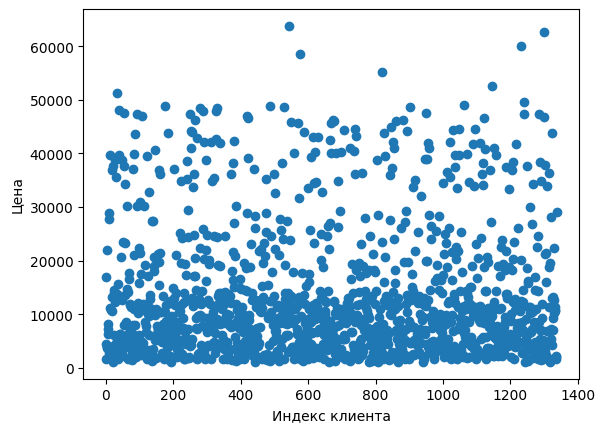

In [3]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

y = insurance_df['charges']

fig, subplot = plt.subplots()
plt.scatter(
    np.arange(len(y)),
    y
)
subplot.set_xlabel('Индекс клиента')
subplot.set_ylabel('Цена')
fig.show()

Получается не очень наглядно - попробуем визуализировать с помощью метода `.hist()` который реализован в pandas

<Axes: >

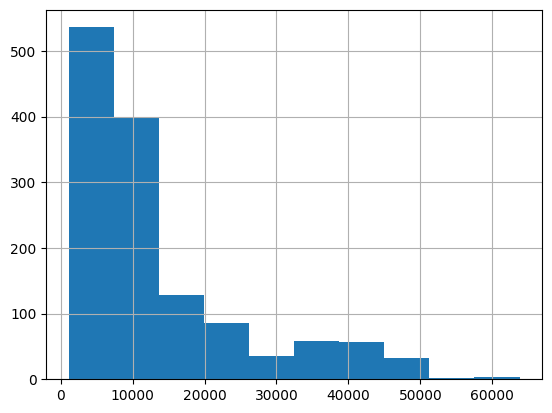

In [4]:
y.hist()

Для каждого объекта построим предсказания с помощью модели линейной регрессии. Воспользуемся как чёрным ящиком питоновским объектом из бибилиотеки [sklearn](https://scikit-learn.org/stable/)

Модели машинного обучения не могут работать с текстом напрямую (вспоминаем лекцию) - а у нас много текстовых полей, их нужно трансформировать в числа - воспользуемся классом `sklearn.preprocessing.LabelEncoder` из библиотеки sklearn

Чтобы преобразовать колонку в текст нужно воспользоваться методом [.fit_transform()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder.fit_transform)

In [5]:
def get_string_cols(df: pd.DataFrame) -> list[str]:
    result = list()
    for col in df:
        if isinstance(df[col][0], str):
            result.append(col)
    return result

In [6]:
string_cols = get_string_cols(insurance_df)
string_cols

['sex', 'smoker', 'region']

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
label_encoder = LabelEncoder()

In [9]:
for col in string_cols:
    insurance_df[col] = label_encoder.fit_transform(
        insurance_df[col].values
    )

In [10]:
insurance_df

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,10600.54830
1334,18,0,31.920,0,0,0,2205.98080
1335,18,0,36.850,0,0,2,1629.83350
1336,21,0,25.800,0,0,3,2007.94500


Обучим линейную регрессию - это класс [sklearn.linear_model.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

Что нужно для счастья
* создать объект
* разделить данные на тренировочные и тестовые
* вызвать метод *.fit()* для тренировочной выборки

Загляните в документацию метода [.fit()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.fit) который принимает на вход два аргумента

* $X$ - матрица объекты - признаки. Удалите из датафрейма `insurance_df` столбец `charges` и сохраните результат в переменную $X$
* $y$ - значение целевой переменной

Для разбиения данных нам понадобится функция `sklearn.model_selection.train_test_split`

Функция принимает несколько аргументов

* `X, y` - первые два аргумента, которые нужно засплиттить
* `test_size=0.33` - доля датасета, которая уйдет в тест
* `random_state=RANDOM_SEED` - фиксирует разбиение

Для чего нужен этот сплит? Модель обучается (то есть подбирает коэффициенты $w_1, ..., w_k$, с помощью которых можно выразить линейную зависимость $y$ от $X$) на тренировочных данных, а потом мы тестируем её качество (т.е. измеряем ошибку) на тестовых.

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [12]:
scaler = StandardScaler()

In [13]:
X = insurance_df.drop("charges", axis=1)
y = insurance_df["charges"].values

In [14]:
X_columns = X.columns
X_columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')

In [15]:
X = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X_columns
)

In [16]:
X

,age,sex,bmi,children,smoker,region
0,-1.438764,-1.010519,-0.453320,-0.908614,1.970587,1.343905
1,-1.509965,0.989591,0.509621,-0.078767,-0.507463,0.438495
2,-0.797954,0.989591,0.383307,1.580926,-0.507463,0.438495
3,-0.441948,0.989591,-1.305531,-0.908614,-0.507463,-0.466915
4,-0.513149,0.989591,-0.292556,-0.908614,-0.507463,-0.466915
...,...,...,...,...,...,...
1333,0.768473,0.989591,0.050297,1.580926,-0.507463,-0.466915
1334,-1.509965,-1.010519,0.206139,-0.908614,-0.507463,-1.372326
1335,-1.509965,-1.010519,1.014878,-0.908614,-0.507463,0.438495
1336,-1.296362,-1.010519,-0.797813,-0.908614,-0.507463,1.343905


In [17]:
y

array([16884.924 ,  1725.5523,  4449.462 , ...,  1629.8335,  2007.945 ,
       29141.3603], shape=(1338,))

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.33,
    random_state=RANDOM_SEED
)

In [20]:
len(X_train), len(X_test), len(y_train), len(y_test)

(896, 442, 896, 442)

In [21]:
reg = LinearRegression()

In [22]:
reg.fit(X_train, y_train)

LinearRegression()

Добавим к датафрейму столбец `prediction`

In [23]:
X_test['prediction'] = reg.predict(X_test)
X_test["charges"] = y_test

In [24]:
X_test

,age,sex,bmi,children,smoker,region,prediction,charges
764,0.412467,-1.010519,-0.900341,0.751079,-0.507463,-1.372326,8784.663103,9095.06825
887,-0.228344,-1.010519,-0.105546,-0.908614,-0.507463,-0.466915,7043.981950,5272.17580
890,1.765289,-1.010519,-0.619825,-0.908614,1.970587,-0.466915,37000.451569,29330.98315
1293,0.483668,0.989591,-0.806836,1.580926,-0.507463,-0.466915,9449.574160,9301.89355
259,-1.438764,0.989591,0.206139,-0.908614,1.970587,-0.466915,27062.629305,33750.29180
...,...,...,...,...,...,...,...,...
644,0.270064,0.989591,0.762250,0.751079,-0.507463,0.438495,11269.626982,18806.14547
602,1.195680,-1.010519,-0.879836,-0.908614,-0.507463,1.343905,10079.598118,11070.53500
731,0.982076,0.989591,-1.519609,-0.078767,-0.507463,1.343905,8461.056486,10065.41300
321,-0.940356,-1.010519,-0.167883,2.410772,-0.507463,-1.372326,6081.197595,24671.66334


Задача - посчитайте эмпирический риск по формуле

$$
Q_{\text{emp}}(h) = \frac{1}{N}\sum_{i=1}^{N}L(h(x_i, \theta), y_i)
$$

где $h(\cdot)$ - значение столбца prediction

Для удобства создайте столбец `squared_loss` - там должно храниться значение $L(y,\hat{y})$:

$L(y,\hat{y}) = (y - \hat{y})^2$

Пользоваться можно только функциями pandas

Полученное значение $Q$ округлите с помощью `np.round(Q, decimals=1)`

In [37]:
def Qemp(df: pd.DataFrame) -> float:
    num_rows = df.shape[0]
    df['squared_loss'] = np.zeros(num_rows)
    df["squared_loss"] = (df["charges"] - df["prediction"])**2
    result = df["squared_loss"].mean()
    print(df)
    return np.round(result, decimals=1)


In [38]:
Qemp(X_test)

           age       sex       bmi  children    smoker    region  \
764   0.412467 -1.010519 -0.900341  0.751079 -0.507463 -1.372326   
887  -0.228344 -1.010519 -0.105546 -0.908614 -0.507463 -0.466915   
890   1.765289 -1.010519 -0.619825 -0.908614  1.970587 -0.466915   
1293  0.483668  0.989591 -0.806836  1.580926 -0.507463 -0.466915   
259  -1.438764  0.989591  0.206139 -0.908614  1.970587 -0.466915   
...        ...       ...       ...       ...       ...       ...   
644   0.270064  0.989591  0.762250  0.751079 -0.507463  0.438495   
602   1.195680 -1.010519 -0.879836 -0.908614 -0.507463  1.343905   
731   0.982076  0.989591 -1.519609 -0.078767 -0.507463  1.343905   
321  -0.940356 -1.010519 -0.167883  2.410772 -0.507463 -1.372326   
479  -1.153959  0.989591  0.311127 -0.908614 -0.507463  0.438495   

        prediction      charges  squared_loss  
764    8784.663103   9095.06825  9.635136e+04  
887    7043.981950   5272.17580  3.139297e+06  
890   37000.451569  29330.98315  5.8820

np.float64(35132017.9)

Визуализируем гистограмму остатков линейной регрессии - это разница между истинным и предсказанным значением.

<Axes: >

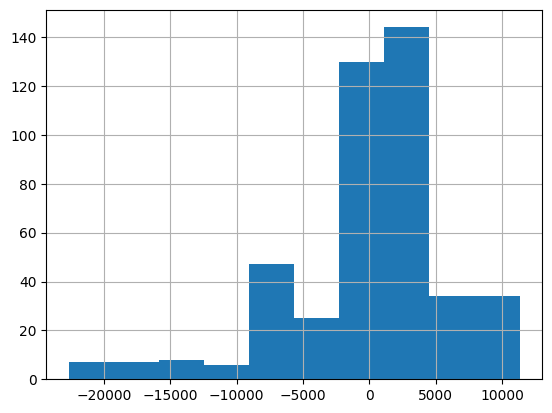

In [27]:
(X_test['prediction'] - y_test).hist()

Кстати, метрику качества необязательно считать вручную - в sklearn реализовано [огромное количество метрик](https://scikit-learn.org/stable/modules/classes.html#regression-metrics) для регрессии (и других задач тоже)

Подробнее о метриках регрессии мы поговорим в дальнейших занятиях

В качестве упражнения посчитайте какую-нибудь метрику - например, MAE - [sklearn.metrics.mean_absolute_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html)

In [28]:
from sklearn.metrics import mean_absolute_error

In [29]:
mean_absolute_error(
    y_test,
    X_test["prediction"]
)

4204.415654724193

Мы поговорили про фичи, про метрики - можно немного углубиться в модель, что представляет собой линейная регрессия?

Задача *линейной* регресии: восстановить на функцию $h(x_i)$ в виде *линейной комбинации* (т.е. суммы с некоторыми весами *важности*) признаков объекта. Сами признаки называются *предикторами*:,
$$
\forall x_i: h(x) = w_0 + w_1x_i^1 + \ldots + w_nx_i^n = \sum_{j=1}^{n}w_jx_i^j = \overline{x}_i^T\overline{w}
$$

К признаковому пространству добавляется "фиктивный" признак $x_0=1$, "важность" которого сохраняется в коэффициент $w_0$.

То есть "семейство функций" представляет собой всевозможные комбинации $[w_0, w_1 , w_2 , w_3 , w_4 , w_5 , w_6]$ а метод *.fit()* волшебным образом подбирает их так, чтобы получить максимальное качество.

Мера качества $L$ для задачи регрессии - квадрат разности между фактическим значением и прогнозом. ,
$$
L(h(x_i, \theta), y_i) = \left(y_i - h(x_i, \theta)\right)^2 = \left(y_i -  \sum_{j=1}^{n}w_jx_i^j\right)^2
$$

/tmp/ipykernel_11756/4042109036.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


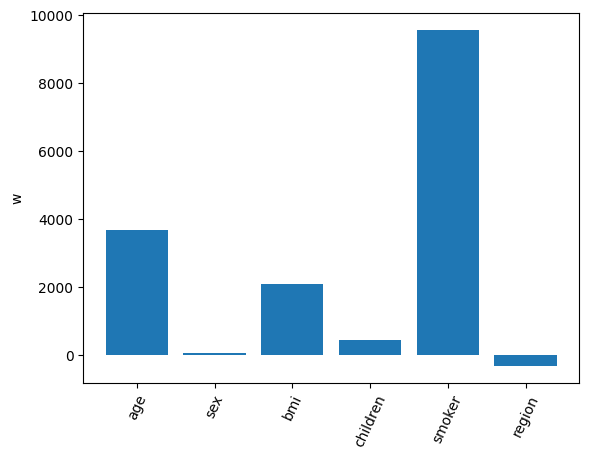

In [30]:
fig, subplot = plt.subplots()
plt.bar(np.arange(len(reg.coef_)), reg.coef_)
subplot.set_xticks(np.arange(len(reg.coef_)))
subplot.set_xticklabels(X.columns.tolist(), rotation=65)
subplot.set_ylabel('w')
fig.show()